In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import camb
from camb import model, initialpower
from camb.sources import GaussianSourceWindow, SplinedSourceWindow
import numpy as np
import sympy as sy
from sympy import symbols
from scipy import interpolate
from scipy import optimize
import matplotlib
from matplotlib import pyplot as plt
import ngfunction

In [4]:
##PARAMETRI INIZIALI

pars = camb.CAMBparams()  #0.022 0.122 67.5
pars.set_cosmology(H0=73, ombh2=0.023, omch2=0.111)   #H0= hubble parameter today in km/s    ombh2=physical density in baryons omch2=physical density in cold dark matter
#trovo densità diverse...
pars.InitPower.set_params(ns=0.965)  #ns = scalar spectra index (inflaction)


class: <InitialPowerLaw>
 tensor_parameterization = tensor_param_rpivot
 ns = 0.965
 nrun = 0.0
 nrunrun = 0.0
 nt = -0.0
 ntrun = -0.0
 r = 0.0
 pivot_scalar = 0.05
 pivot_tensor = 0.05
 As = 2e-09
 At = 1.0
 

In [5]:
pars.set_matter_power(redshifts=[2], kmax=3.0)  
pars.NonLinear = model.NonLinear_none
results = camb.get_results(pars)   

In [6]:
def dist(z):   #funzione per trasformare il redshift in distanza
    return results.comoving_radial_distance(z) #coefficiente per trasformare il redshift in un raggio, c/H0 = [km/s  / (km/s)/Mpc] = [Mpc], z è adimensionale


In [7]:
kh, z, pk = results.get_matter_power_spectrum(minkh=1e-2, maxkh=1e-1, npoints = 100) #nota, le z vengono ordinate, ricavo spettro di potenza

In [8]:
H0 = results.hubble_parameter(0)    #parametri di hubble
h = H0/100
def H(z):
    return results.hubble_parameter(z)

kh = kh/h  #H0 = 70km/(s*Mpc) h=0.7 ma non era senza unità di misura?
pk = pk*h**3

In [9]:
bias = 1 + z[0]*0.84   #funzione di bias delle galassie, cercane altre!!
f = (results.get_fsigma8()/results.get_sigma8())
 #la calcola alla z scelta già, UNITà DI MISURA

mu = np.arange(-1,1,0.1)      #range di valori dell'angolo
N = len(kh)*len(mu)   #numero di dati simulati

In [10]:
#Set di dati simulati spettro di potenza delle galassie

Pgg = np.empty((len(kh),len(mu)))
for i in range (len(kh)):
    for j in range (len(mu)):
        Pgg[i][j] = ( float(np.power(bias + f * np.power(mu[j],2),2)*pk[:,i]))


In [11]:
#Dati per la funzione teorica
#om=(0.134)/(h**2)  #PRESO DA QUELLE INIZIALI MA NON TORNANO COI DATI, ho usato una h diversa
#omb= 0.31  # densità di materia per z=0, presa da libro
om = results.get_Omega('cdm',0) + results.get_Omega('baryon',0)    #densità di materia nell'universo
omz= om*(1+z[0])**3/(H(z[0])/H0)**2 #densità di materia a diverso z
omz

0.8963052488262638

In [12]:
print(f)
print(omz**0.545)

[0.94612751]
0.9420815252777087


In [13]:
##Errori dei dati simulati
ng= ngfunction.Ng(z[0])*10**4/h**3   #mean galaxy number density for z near 0 (Euclid spettroscopy survey)
DeltaMu = np.abs(mu[0]-mu[1])
DeltaZ = 0.1
DeltaK = np.empty((len(kh)))

for i in range (len (kh)):
    if i==0 : DeltaK[i]= np.abs(kh[i+1]-kh[i])
    elif i==len(kh)-1:
       DeltaK[i]= np.abs(kh[i-1]-kh[i])
    else: DeltaK[i]= np.abs(kh[i+1]-kh[i])/2+ np.abs(kh[i-1]-kh[i])/2
    if(DeltaK[i]<1e-2): DeltaK[i]=1e-2   #l'intervallo deve comunque essere più grande di kmin, se non lo è lo metto uguale a kmin
    
N = np.empty((len(kh),len(mu)))
Vol = 4./3.*np.pi*((dist(z[0]+DeltaZ/2))**3-(dist(z[0]-DeltaZ/2)**3))    #calcolo il volume di cielo considerato, inmmagino di guardare il cielo su tutti gli angoli (ideale)

for j in range(len(kh)):
    N[j,:]= Vol*1/(2*np.pi)**2 * kh[j]**2*DeltaMu*DeltaK[j]  #uguale per tutte le mu

err_Pgg = np.empty((len(kh),len(mu)))
for i in range (len(kh)):
    for j in range (len(mu)):
        err_Pgg[i][j] = np.sqrt(2/N[i][j])*(Pgg[i][j]+1/ng)




In [14]:
#cerco la distanza minima, per risalire il kmin da mettere all'inizio del codice

kmin= 2*np.pi/(dist(z[0]+DeltaZ/2)-dist(z[0]-DeltaZ/2))
kmin*h

0.03073494408317064

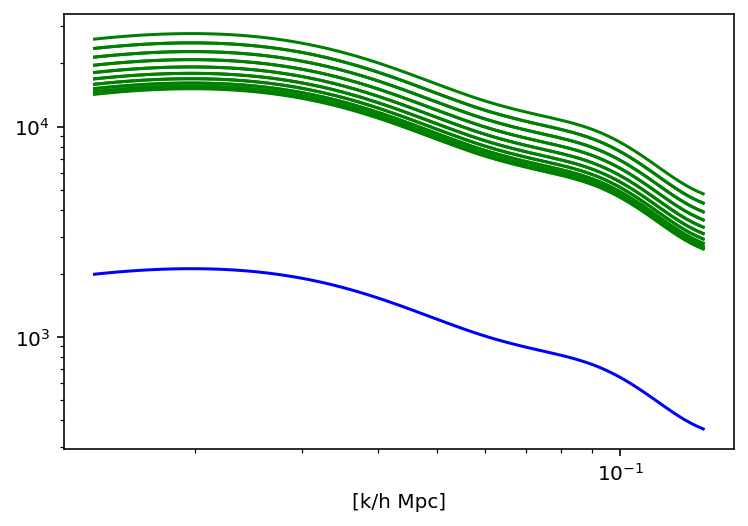

In [15]:
#Grafico

fit, ax = plt.subplots()

ax.set_xlabel('[k/h Mpc]')
ax.set_xscale('log')
ax.set_yscale('log')

ax.plot(kh, pk[0,:], color='b', ls = '-')
for i in range(len(mu)):
    ax.plot(kh, Pgg[:,i], color='g', ls ='-')  #aggiungi gli errori

#ax.legend(['matter','galaxy'], loc='lower left')
#plt.title('Total Matter power at z=%s and z= %s'%tuple(z));

[2387.00738491 2348.46802033 2309.68262851 2270.66269722 2231.42076456
 2191.96824581 2152.31583645 2112.47556869 2072.46084418 2032.28552501
 1991.96331602 1951.5092239  1910.93967671 1870.27190996 1829.52249699
 1788.70904094 1747.85060801 1706.96750795 1666.08019098 1625.20991534
 1584.37928235 1543.61213179 1502.93306207 1462.36740088 1421.94150874
 1381.68269053 1341.61953332 1301.78211872 1262.20105025 1222.90722919
 1183.93243523 1145.3111159  1107.07784203 1069.2664537  1031.91051715
  995.04739662  958.71505126  922.94920157  887.7834982   853.25472889
  819.40185926  786.25996711  753.86009113  722.2341783   691.41902335
  661.44639381  632.3420463   604.1284956   576.83245373  550.47603801
  525.07432202  500.6372381   477.18051936  454.71855235  433.25775731
  412.79730031  393.32592063  374.82338749  357.26633556  340.62912095
  324.8925838   310.05207272  296.09972491  283.02290078  270.79053237
  259.33040277  248.57008425  238.44440637  228.8942011   219.86550533
  211.

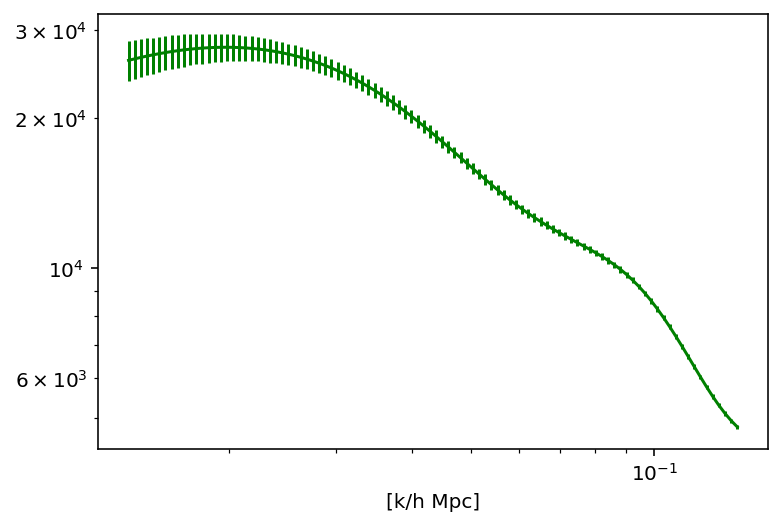

In [16]:
fit, ax = plt.subplots()

ax.set_xlabel('[k/h Mpc]')
ax.set_xscale('log')
ax.set_yscale('log')

ax.errorbar(kh, Pgg[:,0], yerr = err_Pgg[:,0], color='g', ls ='-')  #aggiungi gli errori
print(err_Pgg[:,0])


In [17]:
gammas= np.arange(0.4,0.6,0.005)   #calcolo il chi quadro per un certo set di valori di gamma

for k in range(len(gammas)):
    gammas[k] = round (gammas[k],3)

chi2 = np.zeros(len(gammas))


for k,gamma in enumerate(gammas):
    for i in range (len(kh)):
        for j in range (len(mu)):
            chi2[k]= chi2[k]+(float((bias + (omz**gamma) * (mu[j])**2)**2*pk[:,i]) - Pgg[i][j])**2/err_Pgg[i][j]**2
        



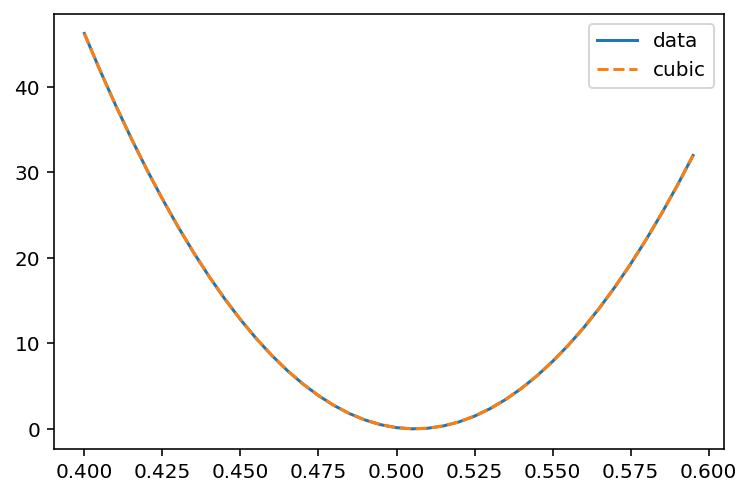

In [18]:
#INTERPOLAZIONE FUNZIONE CHI^2
interpol =  interpolate.interp1d(gammas,chi2,kind='cubic')
plt.plot(gammas,chi2,'-', gammas, interpol(gammas), '--')
plt.legend(['data', 'cubic'])


#plt.axis([0.54,0.56,0,0.4e9])

In [19]:
type(interpol)
y=lambda x: interpol(x)


In [20]:

minimo = optimize.least_squares(y,0.53)
min1= float(minimo.x)
minimo

 active_mask: array([0.])
        cost: 9.891143234088611e-15
         fun: array([1.40649516e-07])
        grad: array([6.74976686e-09])
         jac: array([[0.04798998]])
     message: '`gtol` termination condition is satisfied.'
        nfev: 13
        njev: 13
  optimality: 6.749766861886506e-09
      status: 1
     success: True
           x: array([0.50585938])

In [21]:
chi2min= y(min1)

In [22]:
min2= np.min(chi2)      #trova un valore minimo di chi2, solo a livello discreto, meno preciso
index_min = np.argmin(chi2)
gamma_min = gammas[index_min]
gamma_min

0.505

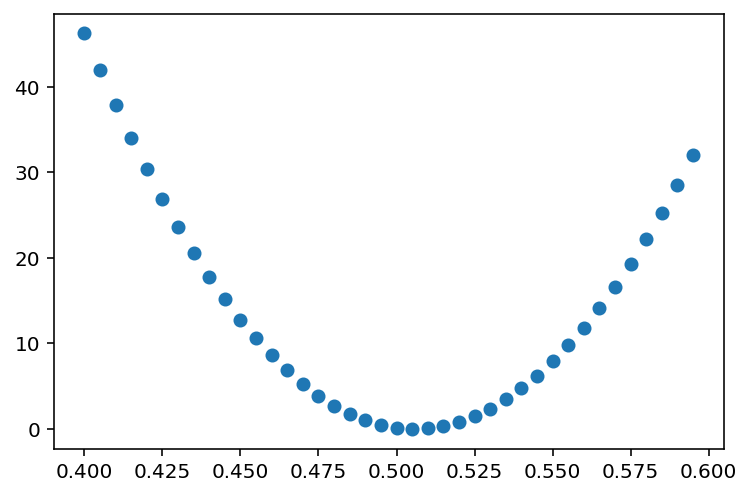

In [23]:
plt.scatter(gammas,chi2)

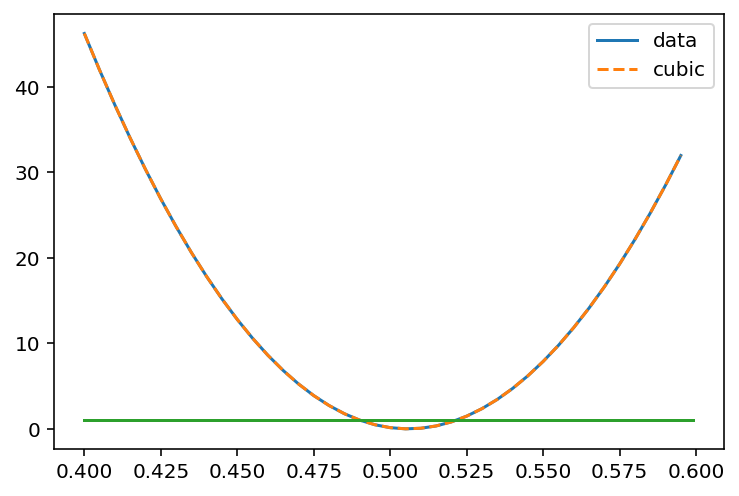

In [24]:
#devo scalare il grafico
plt.plot(gammas,chi2-chi2min,'-', gammas, interpol(gammas)-chi2min, '--')
plt.legend(['data', 'cubic'])

#CALCOLO DELL'ERRORE
xpoints= np.arange(0.4,0.6,0.001)
ypoints = np.ones(len(xpoints))
plt.plot(xpoints,ypoints)



In [25]:
y2= lambda x: interpol(x) - 1 -chi2min
error1 = optimize.brentq(y2,0.45,min1)    #trova le soluzioni in un intervallo fissato
error2 = optimize.brentq(y2,min1,0.57)
print(error1,error2)

0.4901901918822283 0.5215489201866493


In [26]:
print(np.abs(min1-error1))
print(np.abs(min1-error2))

sigma = 0.006

0.015669190980885206
0.01568953732353584


In [27]:
print("Il valore di gamma trovato è: ", round(min1,3) ," +- ", sigma)

Il valore di gamma trovato è:  0.506  +-  0.006


In [28]:
#facciamo il fit, posso usare optimize perché ho l'errore su una sola variabile

#def func(i, gamma):
#    return (bias + (omz**gamma) * (mu[j])**2)**2*pk[:,i]
#
#index = np.array(0,len(kh),1)
#popt, pcov = optimize.curve_fit(func, index , Pgg[:,?], err_Pgg)  #non so che fare con ste mu
